# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

In [1]:
import sys
print (sys.version)

2.7.17 |Anaconda, Inc.| (default, Oct 21 2019, 19:04:46) 
[GCC 7.3.0]


## Quaternion to Euler Testing

In [3]:
def quaternion_to_euler(w, x, y, z):
    """Converts quaternions with components w, x, y, z into a tuple (roll, pitch, yaw)"""
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x**2 + y**2)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    sinp = 2 * (w * y - z * x)
    pitch = np.where(np.abs(sinp) >= 1,
                     np.sign(sinp) * np.pi / 2,
                     np.arcsin(sinp))

    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y**2 + z**2)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

In [4]:
quaternion_to_euler(0.71, 0, 0, 0.71)

(0.0, array(0.), 1.5789294543443066)

In [5]:
3.14/2

1.57

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [ ]:
!pip install -U --pre tensorflow=="2.*"

Make sure you have `pycocotools` installed

In [ ]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [4]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd models/research
pip install .

Processing /home/ch/Documents/GitHub/CSE598-Perception-In-Robotics/project_3b/3b_ws/src/pursuit_evasion/src/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1017522 sha256=ea5b3c98481a518b475cb04a545f975fbc3d82de13d75d98a6e60dfc0fdd761e
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6bw_seg/wheels/02/d2/49/113ead22c9be65843263262790c22323feb7250ad459ee3051
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


### Imports

In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [6]:
cwd = str(pathlib.Path.cwd())

sys.path.append(os.path.join(cwd, 'models/research'))
sys.path.append(os.path.join(cwd, 'models/research/slim'))

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/home/ch/Documents/GitHub/CSE598-Perception-In-Robotics/project_3b/3b_ws/src/pursuit_evasion/src/models/research/object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ch/miniconda3/envs/tf2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/ch/miniconda3/envs/tf2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ch/miniconda3/envs/tf2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ch/miniconda3/envs/tf2/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_in

Patches:

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [9]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

# Detection

Download a pretrained model from the model zoo.

This one will work:
http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

Load an object detection model:

In [10]:
model = tf.saved_model.load('models/ssd_mobilenet_v2_coco_2018_03_29/saved_model/')
detection_model = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [11]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [12]:
detection_model.output_dtypes

{u'detection_boxes': tf.float32,
 u'detection_classes': tf.float32,
 u'detection_scores': tf.float32,
 u'num_detections': tf.float32}

In [13]:
detection_model.output_shapes

{u'detection_boxes': TensorShape([None, 100, 4]),
 u'detection_classes': TensorShape([None, 100]),
 u'detection_scores': TensorShape([None, 100]),
 u'num_detections': TensorShape([None])}

## Functions
Add a wrapper function to call the model, and cleanup the outputs:

In [14]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    print(output_dict)
    return output_dict

Run it on each test image and show the results:

In [15]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

## Test their example images

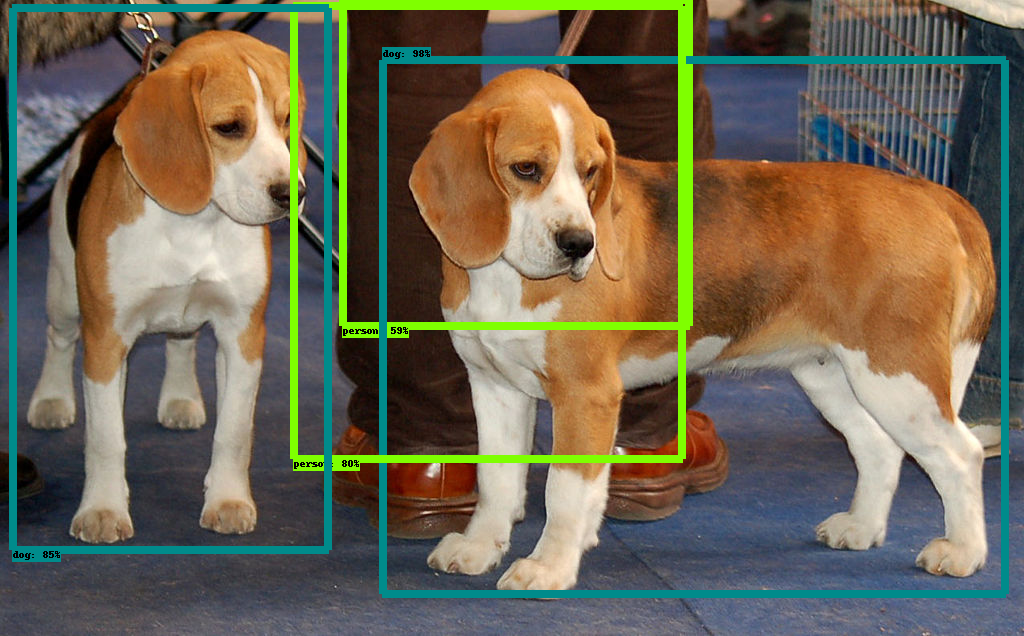

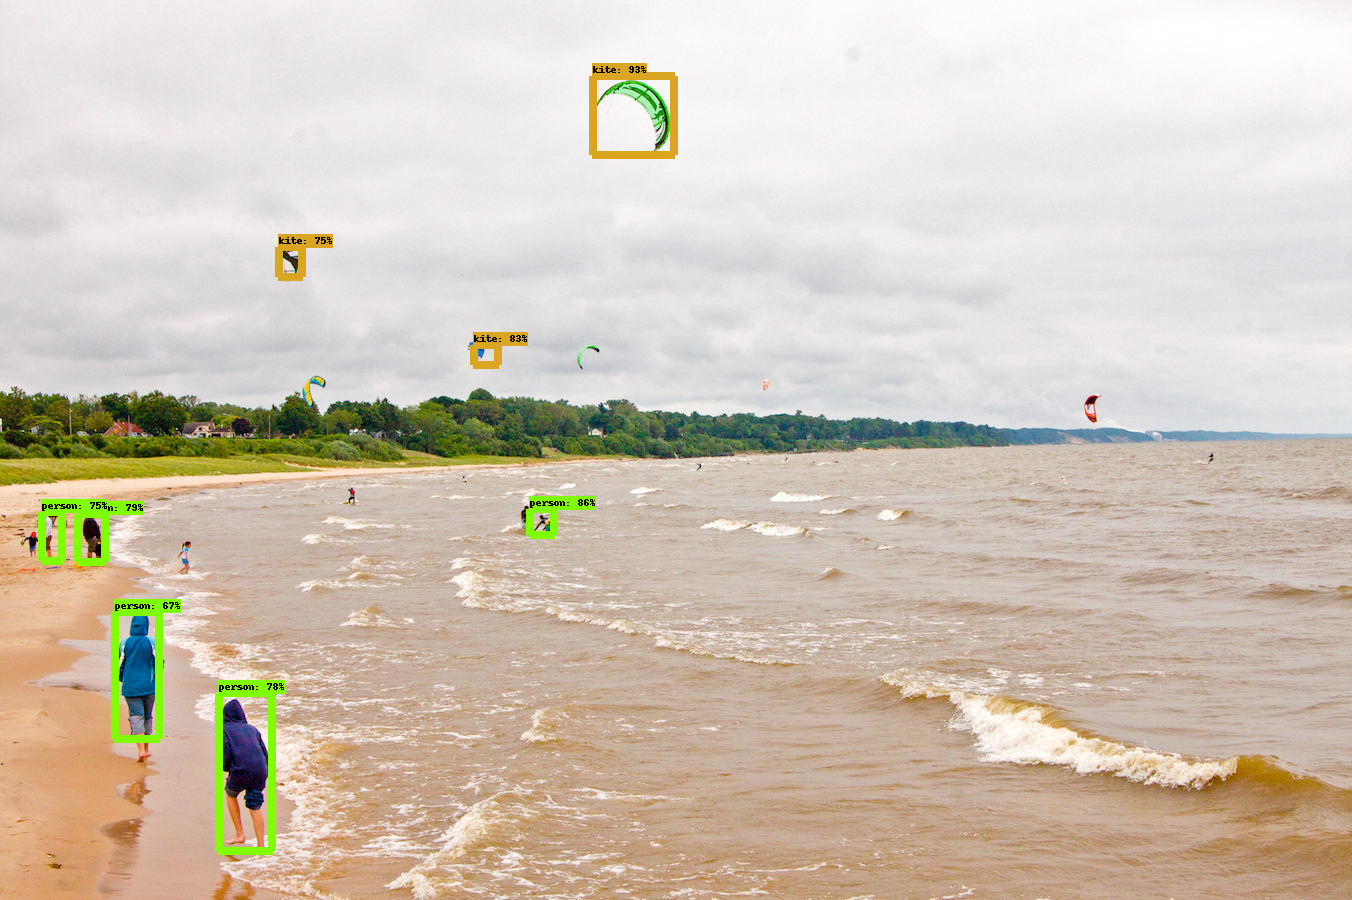

In [36]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

## Test my own images

In [16]:
TEST_IMAGE_PATHS = sorted(pathlib.Path('/home/ch/Pictures/gazebo people').glob('*.jpg'))
TEST_IMAGE_PATHS

[PosixPath('/home/ch/Pictures/gazebo people/gazebo_person.jpg')]

{u'detection_classes': array([1]), u'detection_boxes': array([[3.0305982e-04, 3.1669766e-01, 6.3187075e-01, 6.9868499e-01]],
      dtype=float32), u'detection_scores': array([0.96191406], dtype=float32), 'num_detections': 1}


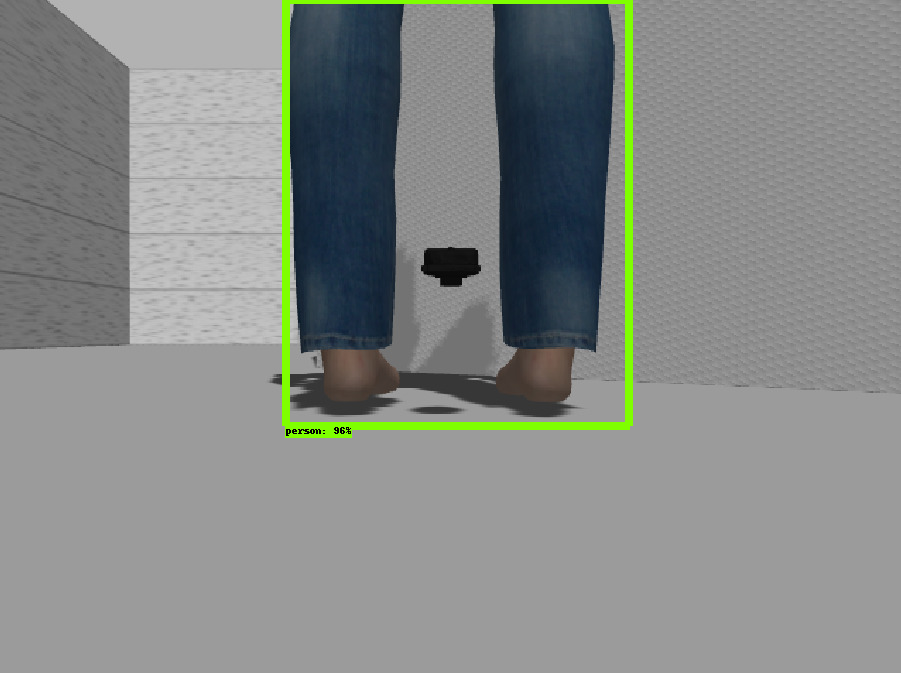

In [17]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

In [ ]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

The instance segmentation model includes a `detection_masks` output:

In [ ]:
masking_model.output_shapes

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)